<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [6]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [8]:
DATA_DIR = os.getcwd() + '\\data'
batch_size = 64
image_presize = 140
image_size = 128
means = [0.5, 0.5, 0.5]
stds = [0.5, 0.5, 0.5]

In [9]:
dataset = ImageFolder(DATA_DIR, transform = tt.Compose(
    [
        tt.Resize((image_presize, image_presize)),
        tt.CenterCrop((image_size, image_size)),
        tt.ToTensor(),
        tt.Normalize(mean=means, std=stds)
     ]))

In [10]:
train_dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [11]:
def denorm(img_tensors):
    for ch in range(3):
        img_tensors[:, ch] = img_tensors[:, ch] * stds[ch] + means[ch]
    return img_tensors

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dataloader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [12]:
latent_size = 64

In [13]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), #128->64
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.01, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), #64->32
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.01, inplace=True),

    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False), #32->16
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.01, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), #16->8
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.01, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), #8->4
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.01, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), #4->1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False), #1->4
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), #4->8
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), #8->16
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False), #16->32
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), #32->64
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False), #64->128
    nn.Tanh()
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [15]:
import copy
from IPython.display import clear_output

In [16]:
def train_model(model, criterion, optimizer, lr_scheduler, epochs, train_dataloader):
    torch.cuda.empty_cache()
    torch.autograd.set_detect_anomaly(False)
    smooth = 0.1

    model["discriminator"].train()
    model["generator"].train()
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        model["discriminator"].train()
        model["generator"].train()
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        counter = 0
        for real_images, _ in train_dataloader:
            counter += 1
            real_images = real_images.to(device)
            
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            # real_targets -= smooth
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            # fake_targets -= smooth
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            # print(1)
            
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())
            
            # print(2)
            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            # print(3)
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            # print(4)
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            # targets -= smooth
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            # print(5)
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        lr_scheduler["generator"].step()
        lr_scheduler["discriminator"].step()

        clear_output(wait=True)
        plt.figure(figsize=(30,10))
        plt.grid(False)
        model["generator"].eval()
        gen_image = model["generator"](torch.randn(1, latent_size, 1, 1, device=device))
        plt.imshow(torch.moveaxis(denorm(gen_image), 1, 3)[0].detach().cpu())
        plt.title('Generate example')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, losses_g[-1]))
        plt.show()

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

    return  losses_g, losses_d, real_scores, fake_scores

In [17]:
lr = 0.0002
epochs = 100

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": torch.optim.AdamW(model["discriminator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.AdamW(model["generator"].parameters(),
                                  lr=lr, betas=(0.5, 0.999))
}

lr_scheduler = {
    "discriminator": torch.optim.lr_scheduler.StepLR(optimizer["discriminator"], step_size=10, gamma=0.5),
    "generator": torch.optim.lr_scheduler.StepLR(optimizer["generator"], step_size=10, gamma=0.5),
}

Запускаем обучение и идем спать (обучение длилось 9 часов)

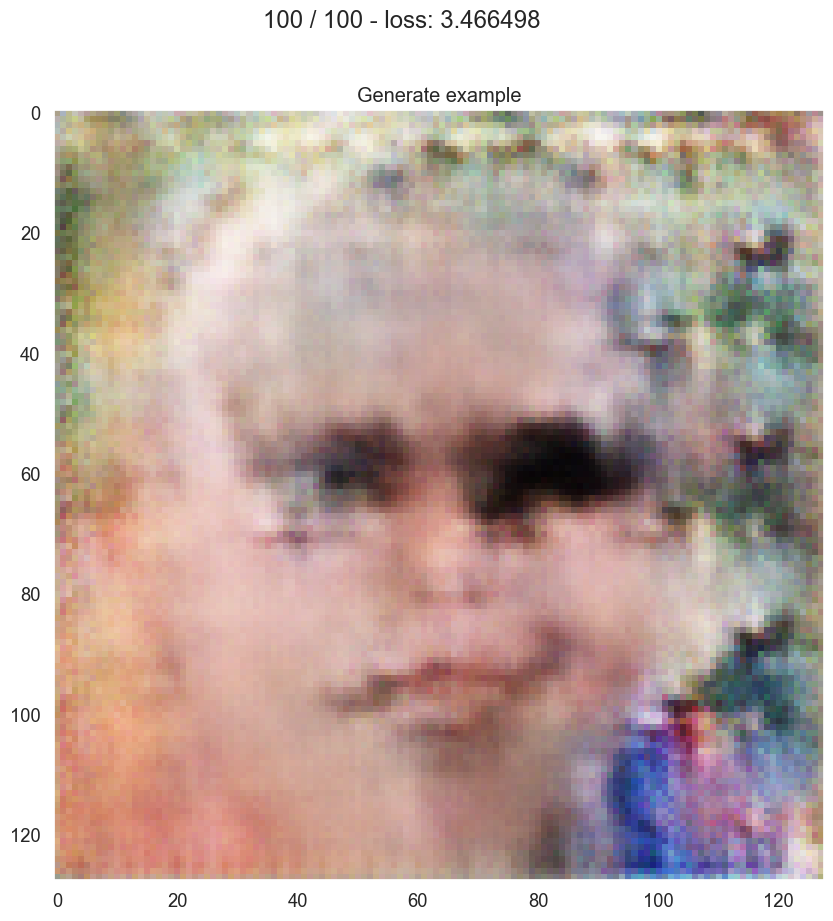

Epoch [100/100], loss_g: 3.4665, loss_d: 0.0938, real_score: 0.9591, fake_score: 0.0466


In [18]:
losses_g, losses_d, real_scores, fake_scores = train_model(model, criterion, optimizer, lr_scheduler, epochs, train_dataloader)

Дообучим еще на 400 эпохах.

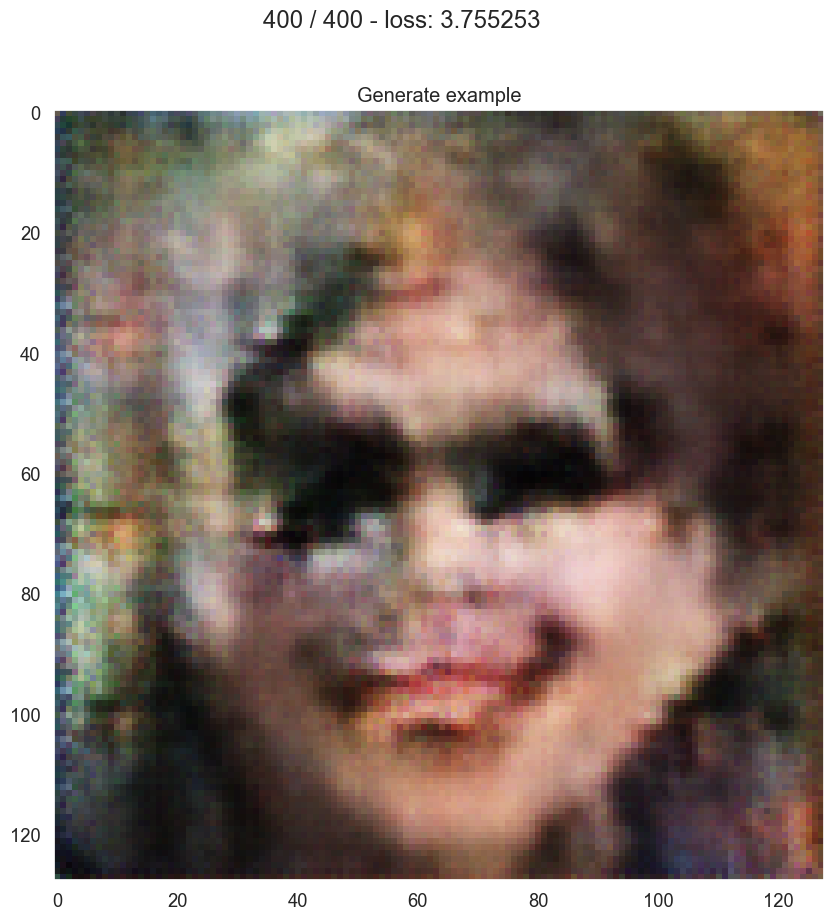

Epoch [400/400], loss_g: 3.7553, loss_d: 0.0720, real_score: 0.9652, fake_score: 0.0334


In [23]:
losses_g1, losses_d1, real_scores1, fake_scores1 = train_model(model, criterion, optimizer, lr_scheduler, 400, train_dataloader)

In [27]:
final_losses_g = losses_g + losses_g1
final_losses_d = losses_d + losses_d1
final_real_scores = real_scores + real_scores1
final_fake_scores = fake_scores + fake_scores1

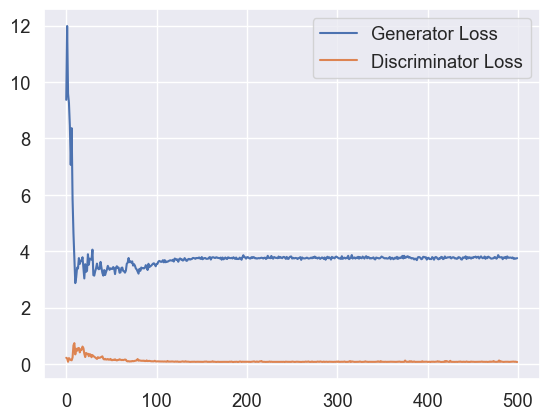

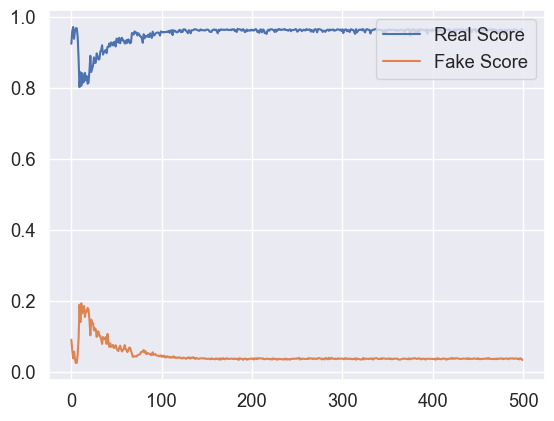

In [28]:
plt.plot(final_losses_g, label="Generator Loss")
plt.plot(final_losses_d, label="Discriminator Loss")
plt.legend(loc="upper right")
plt.show()
plt.plot(final_real_scores, label="Real Score")
plt.plot(final_fake_scores, label="Fake Score")
plt.legend(loc="upper right")
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Лоссы ведут себя ожидаемым образом: рост одного сопровождается падением другого, что понятно, так как модель у нас Generative Adversarial Net. <pr>
Также понятно, что в начале у генератора совсем все плохо и лосс большой, а у дискриминатора наоборот, потом генератор учится делать более или менее правдоподобные фотки, после чего дискриминатор подстраивается под него - это момент максимума лосса дискриминатора и минимума лосса генератора. <pr>
Еще видим, что лоссы модели не менялись начиная с 100 эпохи, так что был смысл обучать не 500 эпох, а 150.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [29]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

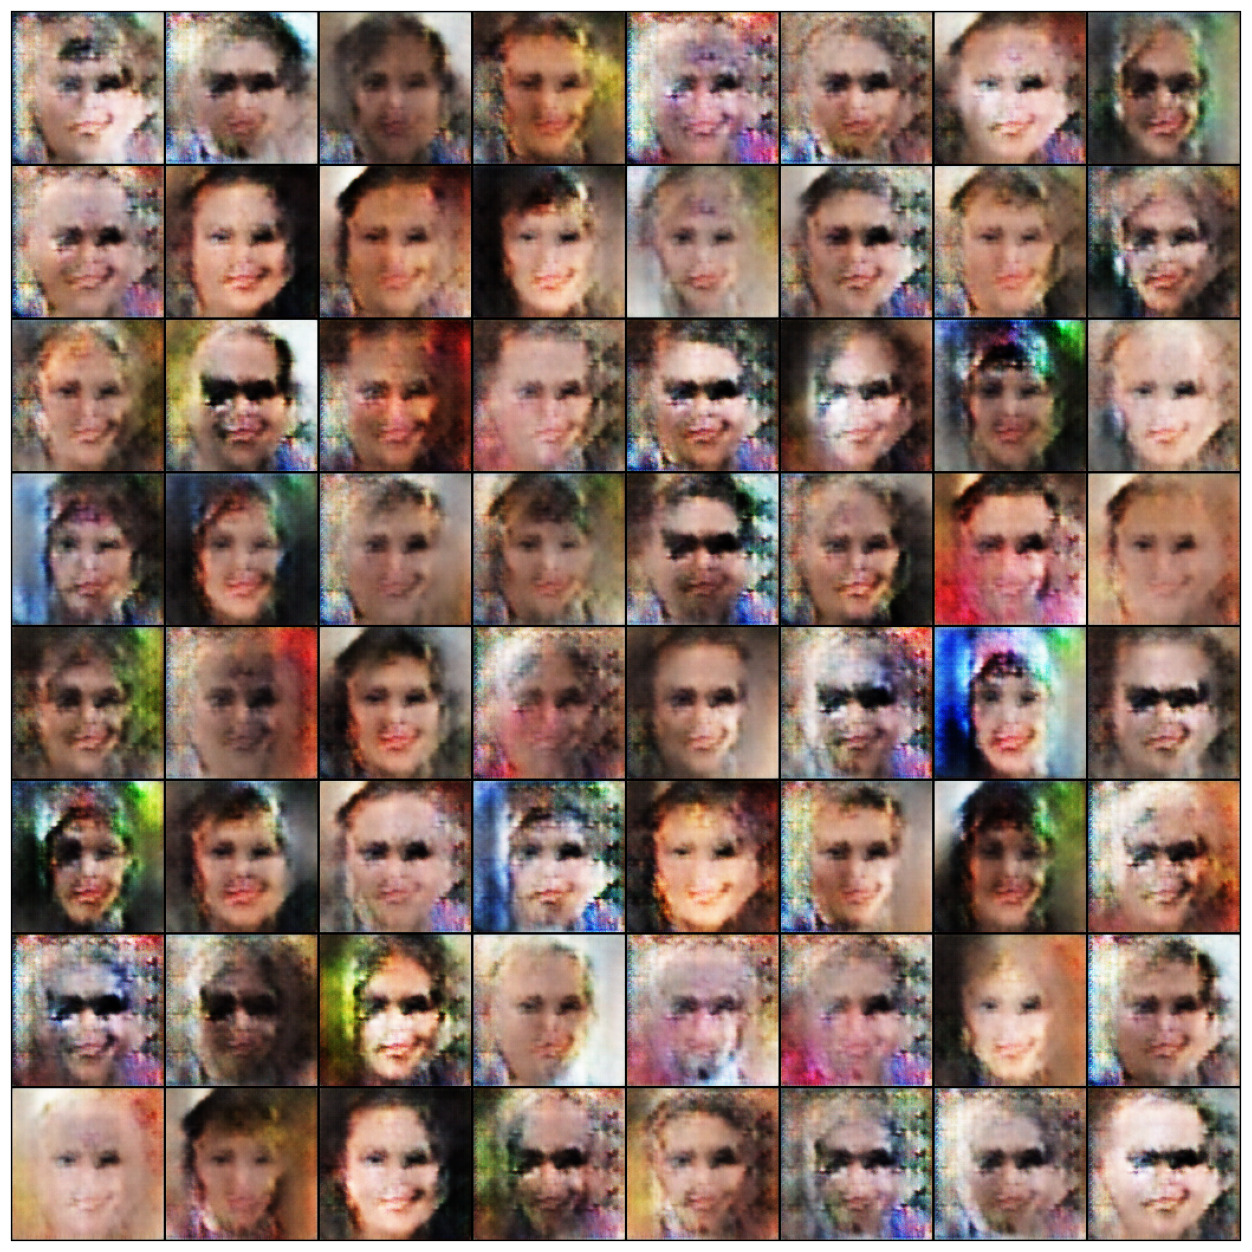

In [30]:
show_images(fake_images.detach().cpu(), n_images)

Как вам качество получившихся изображений?

Могло быть и лучше, но так тоже вполне не плохо, возможно, стоило сделать побольше латентное пространство.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [31]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

In [32]:
fixed_latent = torch.randn(len(dataset), latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [33]:
real_images = [x for x, _ in dataset]
real_images = torch.stack(real_images)
real_images.shape

torch.Size([3143, 3, 128, 128])

In [34]:
real_fake_images = torch.cat((real_images.flatten(1), fake_images.flatten(1).detach().cpu()))
len(real_fake_images)

6286

In [35]:
real_fake_labels = torch.cat((torch.ones(real_images.size(0)), torch.zeros(real_images.size(0))))
len(real_fake_labels)

6286

In [43]:
loo = LeaveOneOut()
true_ans = 0
true_1_ans = 0
true_0_ans = 0

for i, (train_index, test_index) in enumerate(loo.split(real_fake_images)):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(real_fake_images[train_index], real_fake_labels[train_index])
    test_pred = knn.predict(real_fake_images[test_index])
    if (test_pred[0] == real_fake_labels[test_index].item()):
        true_ans += 1
        if (test_pred[0] == 0):
            true_0_ans += 1
        else:
            true_1_ans += 1

print(true_ans, true_0_ans, true_1_ans)

4448 3143 1305


In [45]:
Leave_one_out_1_NN_accuracy = true_ans / real_fake_images.size(0)
accuracy_0 = true_0_ans / real_images.size(0)
accuracy_1 = true_1_ans / real_images.size(0)

print(Leave_one_out_1_NN_accuracy, accuracy_0, accuracy_1)

0.7076041998090996 1.0 0.41520839961819916


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Посмотрим, что из себя представляет полученное значение<pr>
По формуле полной вероятности:<pr>
Leave_one_out_1_NN_accuracy = P(верно угадано | изображение класса 1) * P(изображение класса 1) + P(верно угадано | изображение класса 0) * P(изображение класса 0) = (P(1_true) + P(0_true)) / 2 = 0.746 -> P(1_true) + P(0_true) = 1.415<pr>
В идеале у нас должно было быть 0.5, хотя это и не гарант того, что классы не различимы, но это необходимое условие. То есть если у нас классы не различимы, тогда P(1_true) = P(0_true) = 0.5, но понятно, что это не эквивалентно P(1_true) + P(0_true) = 1. Например, у нас может никогда не предсказываться класс 0, а всегда предсказываться класс 1, что тоже даст нам 0.5.<pr>
В общем, имеет смысл считать отдельно P(1_true) и P(0_true) из-за вышеизложенной причины, что я и сделал.

В целом, метрика показала, что модель обучена далеко не идеально, но считаю, что для учебных целей вполне сойдет.<pr>
Еще интересно получилось, что 0 он угадывает идеально, а 1 с 0.41. Видимо 0 расположены очень близко друг к другу, а 1 более сильно разбросаны.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [39]:
import seaborn as sns
from sklearn import manifold

In [41]:
tsne = manifold.TSNE(
    n_components=2
)
tsne_real_fake_images = tsne.fit_transform(real_fake_images)

<Axes: >

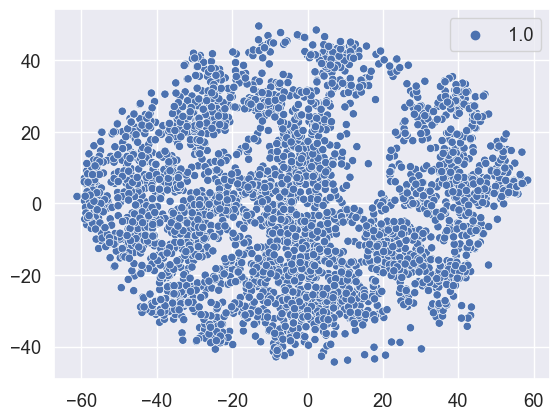

In [46]:
sns.scatterplot(x=tsne_real_fake_images[:real_images.size(0), 0], y=tsne_real_fake_images[:real_images.size(0), 1], hue=real_fake_labels[:real_images.size(0)])

<Axes: >

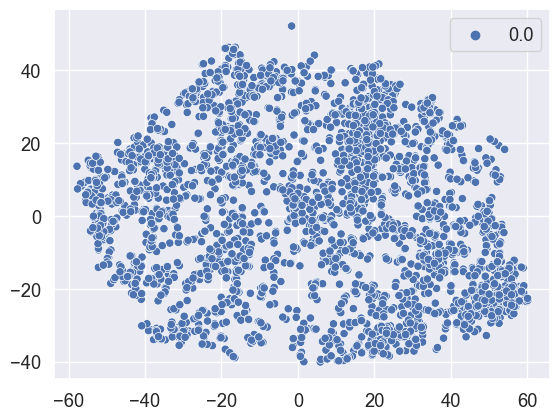

In [47]:
sns.scatterplot(x=tsne_real_fake_images[real_images.size(0):, 0], y=tsne_real_fake_images[real_images.size(0):, 1], hue=real_fake_labels[real_images.size(0):])

<Axes: >

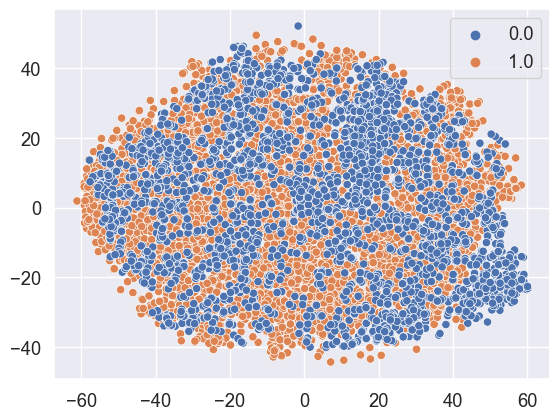

In [42]:
sns.scatterplot(x=tsne_real_fake_images[:, 0], y=tsne_real_fake_images[:, 1], hue=real_fake_labels)

Прокомментируйте получившийся результат:<pr>
Видно, что класс 0 и класс 1 распределены очень похоже, однако класс 0 больше похож на граф, где ребра состоят из элементов класса. Класс 0 распределен очень плотно, из-за чего и получается такое большое acuracy_0.<pr>
Класс 1, напротив, распределен более разрозненно и более равномерно.<pr>
Такое можно объяснить, например тем, что генерация происходит из относительно маленького латентного пространства, из-за чего какие-то лица просто недостижимы при генерации, так что происходит кучкование рядом с лицами, который возможно сгенерировать.